In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import r2_score
import statsmodels.api as sm

%matplotlib inline

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return 

In [6]:
# Load in the dataset
train = pd.read_csv('../datasets/train.csv')

In [7]:
# Load a df as train as to leave an untouched copy of train.
df = train

## Functions

In [8]:
def get_mean(col_name, by='neighborhood', df=df):
    """Gets the mean of col_name based off of by and returns dict"""
    neighborhood = list(df[by].unique())
    neighborhood_dict = {}
    for a in neighborhood:
        mean = df.loc[(df[by] == a) & (~df[col_name].isna()), col_name].mean()
        neighborhood_dict[a] = mean
    return neighborhood_dict

In [9]:
def fill_na_mean(mean_dict, col_name, by='neighborhood', df=df):
    """Fills na of given col_name with mean from mean_dict."""
    for name, mean in mean_dict.items():
        df.loc[(df[by] == name) & (df[col_name].isna()), col_name] = mean

## Data Cleaning

In [10]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,...,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,...,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,...,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,...,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,...,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [11]:
# Fix column names to remove spaces and lowercase for easier calling.
df.columns = df.columns.map(lambda col: col.lower().replace(' ', '_'))

In [12]:
# Check for na
col_na = df.isna().any()
df.loc[:, col_na].columns

Index(['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type',
       'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature'],
      dtype='object')

#### Filling Nulls

In [13]:
# MAS VNR AREA
mas_vnr_area_mean = get_mean('mas_vnr_area', by='mas_vnr_type')

del mas_vnr_area_mean[float(np.nan)]

fill_na_mean(mas_vnr_area_mean, 'mas_vnr_area', by='mas_vnr_type')

df['mas_vnr_area'].fillna(0, inplace=True)

# BSMT FIN SF 1
temp_dict = get_mean('bsmtfin_sf_1', by='bsmtfin_type_1')

del temp_dict[float(np.nan)]

fill_na_mean(temp_dict, 'bsmtfin_sf_1', by='bsmtfin_type_1')

df['bsmtfin_sf_1'].fillna(0, inplace=True)

# BSMT FIN SF 2
temp_dict = get_mean('bsmtfin_sf_2', by='bsmtfin_type_2')

del temp_dict[float(np.nan)]

fill_na_mean(temp_dict, 'bsmtfin_sf_2', by='bsmtfin_type_2')

df['bsmtfin_sf_2'].fillna(0, inplace=True)

# BSMT UNF SF
temp_dict = get_mean('bsmt_unf_sf', by='bsmtfin_type_1')

del temp_dict[float(np.nan)]

fill_na_mean(temp_dict, 'bsmt_unf_sf', by='bsmtfin_type_1')

df['bsmt_unf_sf'].fillna(0, inplace=True)

# BSMT TOTAL SF
total_sf = df['bsmtfin_sf_1'] + df['bsmt_unf_sf']

df[df['total_bsmt_sf'].isna()].id

df['total_bsmt_sf'].fillna(total_sf[1326], inplace=True)

# BSMT FULL BATH
temp_dict = get_mean('bsmt_full_bath', by='bsmtfin_type_1')

del temp_dict[float(np.nan)]

fill_na_mean(temp_dict, 'bsmt_full_bath', by='bsmtfin_type_1')

df['bsmt_full_bath'].fillna(0, inplace=True)

# BSMT Half BATH
temp_dict = get_mean('bsmt_half_bath', by='bsmtfin_type_1')

del temp_dict[float(np.nan)]

fill_na_mean(temp_dict, 'bsmt_half_bath', by='bsmtfin_type_1')

df['bsmt_half_bath'].fillna(0, inplace=True)

# Lot Frontage <-- Not important
lot_frontage_mean = get_mean('lot_frontage')
fill_na_mean(lot_frontage_mean, 'lot_frontage')
house_style_mean = get_mean('lot_frontage', by='house_style')
fill_na_mean(house_style_mean, 'lot_frontage', by='house_style')

# Garage
years = df[df['garage_yr_blt'].isna()]['year_built']
df.loc[df['garage_yr_blt'].isna(), 'garage_yr_blt'] = years
df['garage_cars'].fillna(0, inplace=True)
df['garage_area'].fillna(0, inplace=True)

#### Creating Columns

In [14]:
# Alley
df = pd.get_dummies(df, columns=['alley'])

# Mas vnr type
df = pd.get_dummies(df, columns=['mas_vnr_type'], drop_first=True)

# Bsmt
df = pd.get_dummies(df, columns=['bsmt_qual'])
df = pd.get_dummies(df, columns=['bsmt_cond'])
df = pd.get_dummies(df, columns=['bsmt_exposure'])
df = pd.get_dummies(df, columns=['bsmtfin_type_1'])
df = pd.get_dummies(df, columns=['bsmtfin_type_2'])

# Fireplace
df = pd.get_dummies(df, columns=['fireplace_qu'])

# Garage
df = pd.get_dummies(df, columns=['garage_type'])
df = pd.get_dummies(df, columns=['garage_finish'])
df = pd.get_dummies(df, columns=['garage_qual'])
df = pd.get_dummies(df, columns=['garage_cond'])

# Pool
df = pd.get_dummies(df, columns=['pool_qc'])

# Fence
df = pd.get_dummies(df, columns=['fence'])

In [15]:
# Drop misc feature
df.drop(columns='misc_feature', inplace=True)

In [16]:
df_cat = pd.get_dummies(df, columns=df.select_dtypes(include='object').columns, drop_first=True)

data = df_cat.drop(columns='saleprice')

num_col = data._get_numeric_data().columns

In [17]:
test = pd.read_csv('../datasets/test_clean.csv')

In [18]:
# Fix unmatching data between training and testing data w/o bleed
missing = []

for col in data:
    if col not in test:
        missing.append(col)

data.drop(columns=missing, inplace=True)

missing = []
for col in test:
    if col not in data:
        missing.append(col)

test.drop(columns=missing, inplace=True)

In [19]:
# Load out clean data
df.to_csv('../datasets/train_clean.csv', index=1)

## Data Exploration

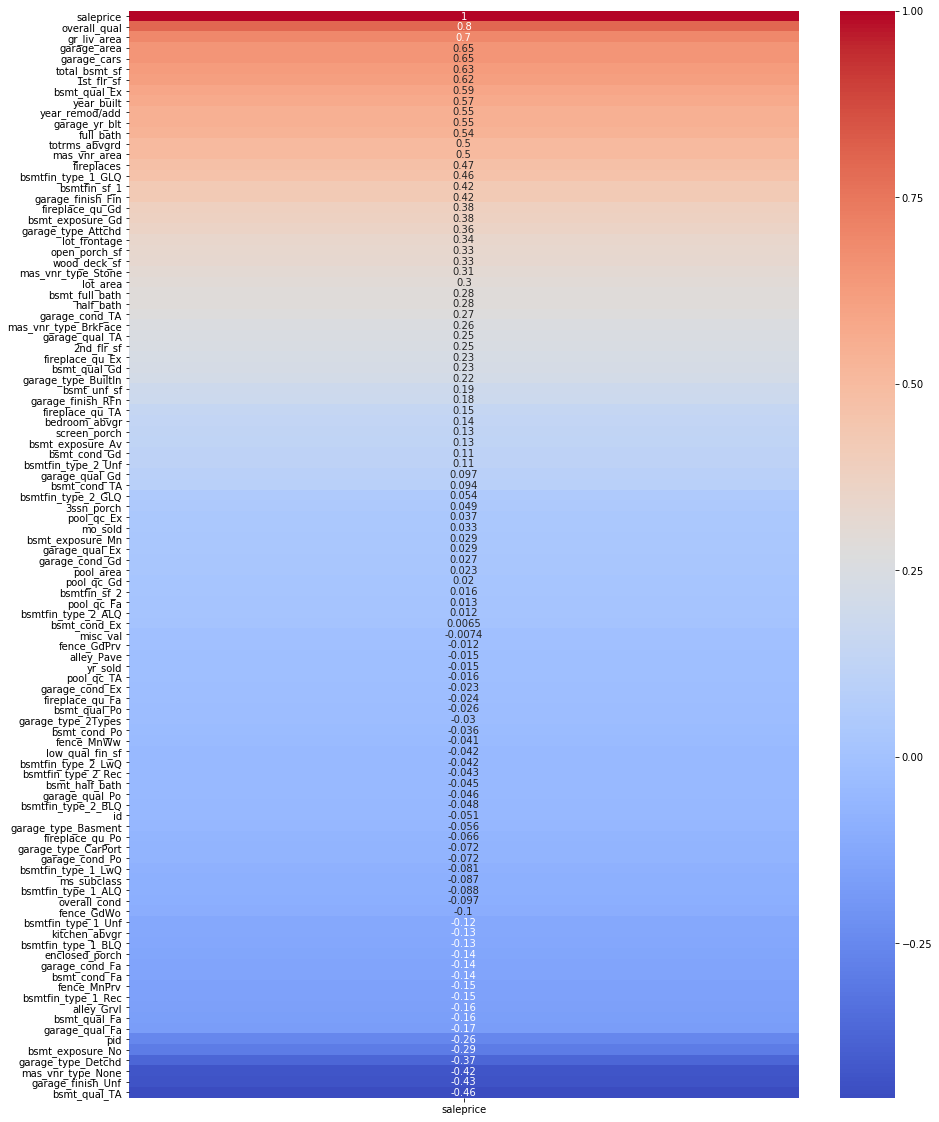

In [20]:
plt.figure(figsize=(15,20));
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice', ascending=False), cmap='coolwarm', annot=True);

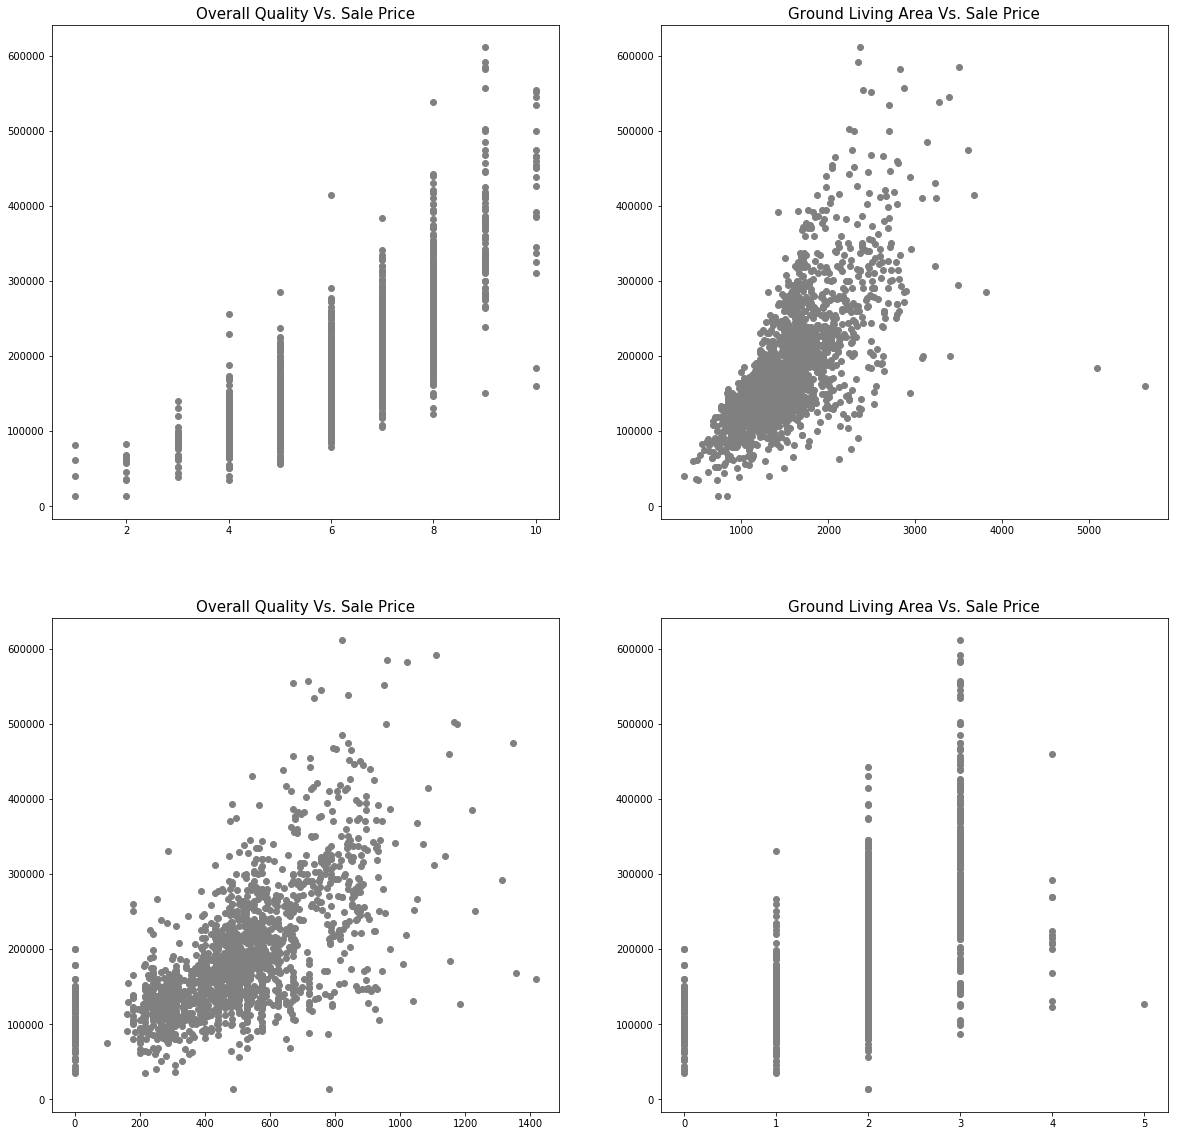

In [21]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

# Overall Quality
x = df['overall_qual']
y = df['saleprice']
overall_qual_g = ax1.scatter(x, y, color='grey');
ax1.set_title('Overall Quality Vs. Sale Price', size=15);

# Ground Living Area
x = df['gr_liv_area']
y = df['saleprice']
gr_liv_area_g = ax2.scatter(x, y, color='grey');
ax2.set_title('Ground Living Area Vs. Sale Price', size=15);

# Garage Area
x = df['garage_area']
y = df['saleprice']
overall_qual_g = ax3.scatter(x, y, color='grey');
ax3.set_title('Overall Quality Vs. Sale Price', size=15);

# Garage Cars
x = df['garage_cars']
y = df['saleprice']
gr_liv_area_g = ax4.scatter(x, y, color='grey');
ax4.set_title('Ground Living Area Vs. Sale Price', size=15);

In [22]:
df.corr()['saleprice'].sort_values(ascending=False).index[5:9]

Index(['total_bsmt_sf', '1st_flr_sf', 'bsmt_qual_Ex', 'year_built'], dtype='object')

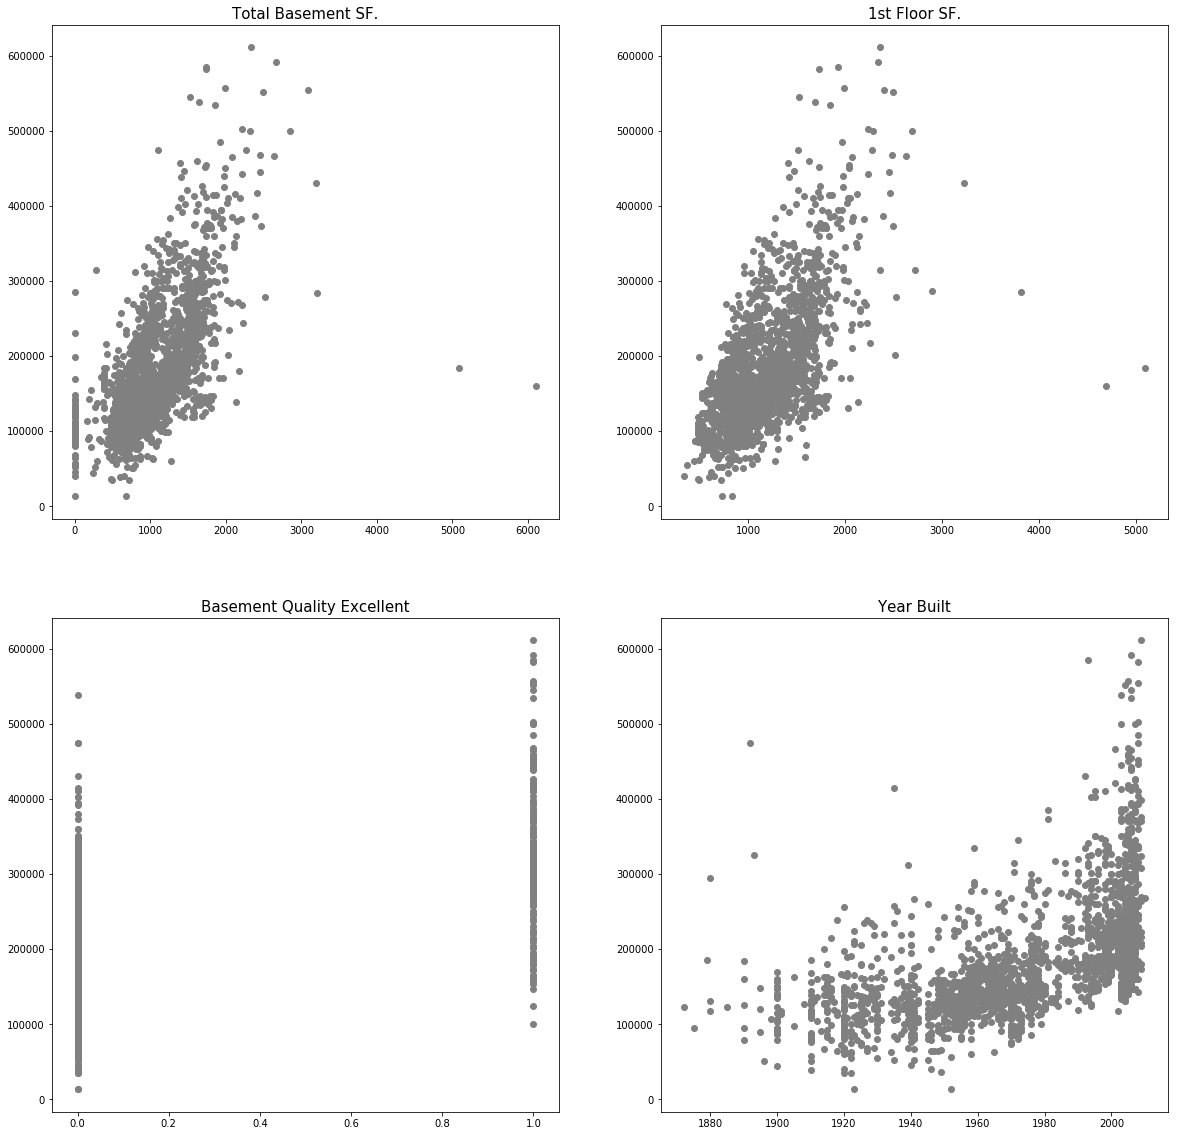

In [23]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

# Total Basement SF.
title1 = 'Total Basement SF.'
x = df['total_bsmt_sf']
y = df['saleprice']
overall_qual_g = ax1.scatter(x, y, color='grey');
ax1.set_title(title1, size=15);

# 1st Floor SF.
title2 = '1st Floor SF.'
x = df['1st_flr_sf']
y = df['saleprice']
gr_liv_area_g = ax2.scatter(x, y, color='grey');
ax2.set_title(title2, size=15);

# Basement Quality Excellent
title3 = 'Basement Quality Excellent'
x = df['bsmt_qual_Ex']
y = df['saleprice']
overall_qual_g = ax3.scatter(x, y, color='grey');
ax3.set_title(title3, size=15);

# Year Built
title4 = 'Year Built'
x = df['year_built']
y = df['saleprice']
gr_liv_area_g = ax4.scatter(x, y, color='grey');
ax4.set_title(title4, size=15);

## Modeling

In [24]:
# Getting numericat columns
num_col = data._get_numeric_data().columns

# Setting the features requires removing the first two columns
features = num_col[2:]

# Setting X train
X_train = data[features]

# Setting y train
y_train = df['saleprice']

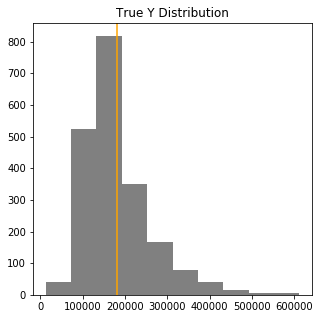

In [25]:
# Check for distribution in y
plt.figure(figsize=(5,5))
plt.hist(y_train, color='grey');
plt.axvline(np.mean(y_train), color='orange');
plt.title('True Y Distribution');

In [26]:
pt = PowerTransformer()

X_train = pt.fit_transform(X_train)

pt_y = PowerTransformer()

pt_y.fit(y_train.to_frame())

y_train_pt = pt_y.transform(y_train.to_frame())

lasso = LassoCV(n_alphas=200, cv=10, n_jobs=-1)

lasso.fit(X_train, y_train_pt)

X_test = test[features]

X_test_pt = pt.fit_transform(X_test)

predictions = lasso.predict(X_test_pt)

predictions = pt_y.inverse_transform(predictions.reshape(-1,1))

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


## Evaluate Model

In [27]:
# Load in coef with matching feature names
coef_df = pd.DataFrame(lasso.coef_, features)

# Create a mask to get rid of unused columns
mask = (coef_df[0] != 0).values

# Create new column features
new_features = list(coef_df[mask].index)

## Retrain Model

In [28]:
# Second run through to retrain
X_train = data[new_features]

pt = PowerTransformer()

X_train = pt.fit_transform(X_train)

pt_y = PowerTransformer()

pt_y.fit(y_train.to_frame())

y_train_pt = pt_y.transform(y_train.to_frame())

lasso = LassoCV(n_alphas=200, cv=10, n_jobs=-1)

lasso.fit(X_train, y_train_pt)

X_test = test[new_features]

X_test_pt = pt.fit_transform(X_test)

predictions = lasso.predict(X_test_pt)

predictions = pt_y.inverse_transform(predictions.reshape(-1,1))

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


# EDIT

# END

## Submission

In [70]:
# Load sale price predictions
test['saleprice'] = predictions

# Correct Column names for submission
test.rename(columns={'id': 'Id', 'saleprice': 'SalePrice'}, inplace=True)

# Create submission variable
submission = test[['Id', 'SalePrice']]

# Submission notes for save
ext = '../datasets/'
date = '23Mar2019'
version = 'v2'
f = ext + date + version

# Turn submission into csv for upload
submission.to_csv(f, index=False)